# 相关文章:
参考该文章,学习VAE的原理,提交学习笔记
https://blog.csdn.net/m0_56942491/article/details/136265500

# 数据准备：MNIST 数据加载
1.我们首先加载数据，VAE 学习的是数据的分布，所以我们需要大量的样本让它明白‘手写数字’长什么样。

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transform = transforms.ToTensor()

train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    download=True,
    transform=transform
)

test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    download=True,
    transform=transform
)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

# 模型定义:
### 2. 模型定义：卷积变分自编码器 (ConvVAE)
VAE 与普通自编码器（AE）最大的不同在于：它不将图像压缩为一个“点”，而是压缩为一个**概率分布**。

#### 核心组件：
1. **Encoder (编码器)**：使用卷积层（Conv2d）逐步下采样，提取高维特征。最后输出两个向量：**均值 ($\mu$)** 和 **方差的对数 ($\log \sigma^2$)**。
2. **Reparameterization (重参数化)**：这是 VAE 的核心。
   * 直接从分布采样是不可导的，无法反向传播。
   * 我们通过 $z = \mu + \epsilon \cdot \sigma$（其中 $\epsilon \sim \mathcal{N}(0, 1)$）来引入随机性，同时保持梯度的流动。
3. **Decoder (解码器)**：接收潜变量 $z$，通过转置卷积（ConvTranspose2d）逐步还原回 28x28 的图像。

In [2]:
import torch.nn as nn
import torch.nn.functional as F

class ConvVAE(nn.Module):
    def __init__(self, latent_dim=2):  # 设为2方便可视化
        super().__init__()

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 4, 2, 1),  # 28→14
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, 2, 1), # 14→7
            nn.ReLU(),
            nn.Flatten()
        )

        self.fc_mu = nn.Linear(64 * 7 * 7, latent_dim)
        self.fc_logvar = nn.Linear(64 * 7 * 7, latent_dim)

        # Decoder
        self.fc_decode = nn.Linear(latent_dim, 64 * 7 * 7)

        self.decoder = nn.Sequential(
            nn.Unflatten(1, (64, 7, 7)),
            nn.ConvTranspose2d(64, 32, 4, 2, 1),  # 7→14
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 4, 2, 1),   # 14→28
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = self.fc_decode(z)
        return self.decoder(h)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

### 3. 损失函数：证据下界 (ELBO)
VAE 的训练目标是最大化证据下界，体现在代码中是最小化两个损失之和：

$$Loss = \text{Reconstruction Loss} + \text{KL Divergence}$$

* **重构损失 (BCE)**：衡量生成图与原图的相似度。它迫使模型把图画“准”。
* **KL 散度 (KL Divergence)**：衡量潜空间分布与标准正态分布 $\mathcal{N}(0, 1)$ 的差异。它迫使模型把潜空间排布“整齐”，防止过拟合。

In [3]:
def loss_function(x_recon, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(x_recon, x, reduction='sum')

    kl_loss = -0.5 * torch.sum(
        1 + logvar - mu.pow(2) - logvar.exp()
    )

    return recon_loss + kl_loss

### 4. 训练模型


In [4]:
model = ConvVAE(latent_dim=2).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

epochs = 10

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for x, _ in train_loader:
        x = x.to(device)

        x_recon, mu, logvar = model(x)
        loss = loss_function(x_recon, x, mu, logvar)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader.dataset):.4f}")

Epoch 1, Loss: 193.7677
Epoch 2, Loss: 169.9003
Epoch 3, Loss: 164.5462
Epoch 4, Loss: 161.0402
Epoch 5, Loss: 158.9548
Epoch 6, Loss: 157.4750
Epoch 7, Loss: 156.4433
Epoch 8, Loss: 155.6129
Epoch 9, Loss: 154.9478
Epoch 10, Loss: 154.3800


### 5. 可视化：重建效果对比
我们从测试集中取出几张图，送入模型，观察输出。
* **上排**：原始图像。
* **下排**：VAE 重建后的图像。


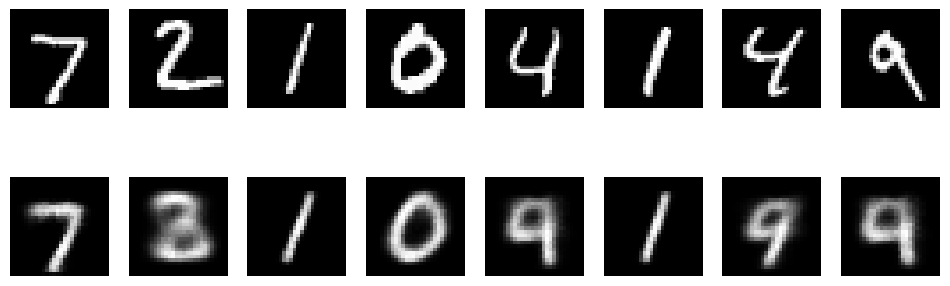

In [5]:
model.eval()

with torch.no_grad():
    x, _ = next(iter(test_loader))
    x = x.to(device)
    x_recon, _, _ = model(x)

x = x.cpu()
x_recon = x_recon.cpu()

fig, axes = plt.subplots(2, 8, figsize=(12,4))

for i in range(8):
    axes[0,i].imshow(x[i].squeeze(), cmap='gray')
    axes[0,i].axis('off')
    axes[1,i].imshow(x_recon[i].squeeze(), cmap='gray')
    axes[1,i].axis('off')

plt.show()

### 6. 潜空间分布：数字的“秘密地图”
我们将 2D 潜变量 $z$ 的坐标画出来，并用颜色标注对应的数字。
* **聚类现象**：我们发现模型在**完全没有标签**的情况下，自动将相同数字的图片聚集在了一起。
* **连续性**：不同颜色的边界处，往往是长得比较像的数字（例如 4, 7, 9）。
* **正态分布约束**：由于 KL 散度的存在，所有的点都分布在原点附近的一个圆形区域内，没有出现孤立的“死区”。

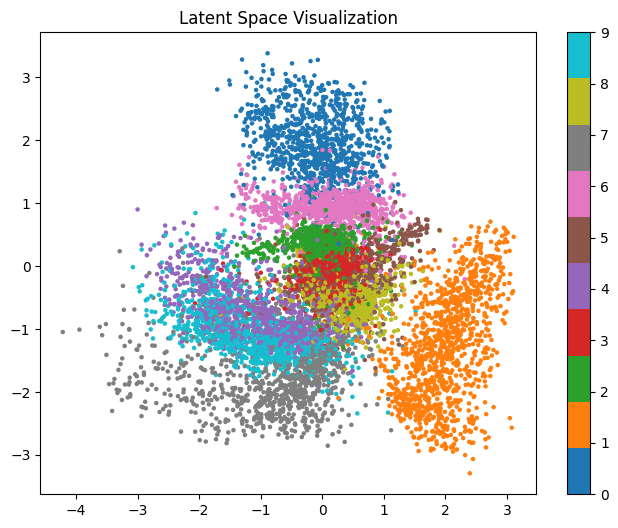

In [6]:
import numpy as np

model.eval()
all_mu = []
all_labels = []

with torch.no_grad():
    for x, y in test_loader:
        x = x.to(device)
        mu, _ = model.encode(x)
        all_mu.append(mu.cpu())
        all_labels.append(y)

all_mu = torch.cat(all_mu)
all_labels = torch.cat(all_labels)

plt.figure(figsize=(8,6))
plt.scatter(all_mu[:,0], all_mu[:,1], c=all_labels, cmap='tab10', s=5)
plt.colorbar()
plt.title("Latent Space Visualization")
plt.show()

### 7. 潜空间流形：
我们在潜空间 $[-3, 3]$ 的范围内均匀采样，并将这些坐标输入 Decoder。
* **平滑过渡**：观察图像的变化。你可以清晰地看到一个数字如何通过形状的连续扭曲，平滑地变成了另一个数字（例如 0 逐渐变扁成为 1）。
* **创造力**：网格中的很多图像在原始数据集中并不存在，它们是模型通过学习到的“数字规律”创造出来的全新手写体。
* **结构化**：这证明了我们的 VAE 已经学会了数字的底层特征（倾斜度、粗细、闭合程度等）。

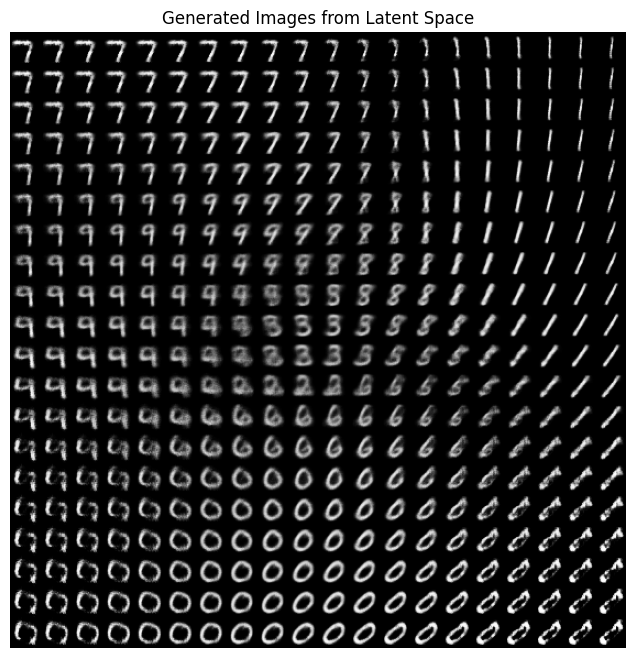

In [7]:
grid_x = torch.linspace(-3, 3, 20)
grid_y = torch.linspace(-3, 3, 20)

canvas = torch.zeros(20*28, 20*28)

for i, yi in enumerate(grid_y):
    for j, xi in enumerate(grid_x):
        z = torch.tensor([[xi, yi]]).to(device)
        with torch.no_grad():
            img = model.decode(z).cpu()
        canvas[i*28:(i+1)*28, j*28:(j+1)*28] = img.squeeze()

plt.figure(figsize=(8,8))
plt.imshow(canvas, cmap='gray')
plt.axis('off')
plt.title("Generated Images from Latent Space")
plt.show()